# 1. Deep Learning for Vision

**Upside down detector**: Train a model to detect if images are upside down

* Pick a dataset of natural images (we suggest looking at datasets on the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads))
* Synthetically turn some of images upside down. Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

# Dataset :

*   I choose the cat_vs_dogs datasets which is uploaded in the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads)
*   In this Dataset i extract the cat class, for this coding challenge.



## Importing Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
import cv2
import os,shutil,json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib._png import read_png
from matplotlib.cbook import get_sample_data

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models, losses, Model
import tensorflow_datasets as tfds

In [2]:
pip install datasets

     |████████████████████████████████| 325 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 27.8 MB/s 
     |████████████████████████████████| 212 kB 11.6 MB/s 
     |████████████████████████████████| 136 kB 26.2 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 127 kB 48.2 MB/s 
     |████████████████████████████████| 271 kB 48.4 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 144 kB 39.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


**Get the dataset from the datasets libaray.**

In [8]:
from datasets import load_dataset
dataset = load_dataset("cats_vs_dogs", ignore_verifications=True )
data = pd.DataFrame.from_dict(dataset['train']) # Sorting only cat class
data = data.loc[data['labels'] == 0]
data.reset_index(inplace = True, drop = True)
upside_down, normal = data[(len(data)//2):], data[:(len(data)//2)]

Using custom data configuration default
Reusing dataset cats_vs_dogs (/root/.cache/huggingface/datasets/cats_vs_dogs/default/0.0.1/cf5b67b98947a9581c08ea2cc3ba991540f5df2b8fb727f703c48fc0200ba52c)


  0%|          | 0/1 [00:00<?, ?it/s]

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


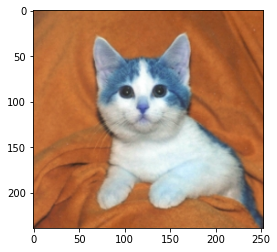

In [4]:
%pylab inline
img = mpimg.imread(data.image_file_path[0])
img = cv2.imread(data.image_file_path[0])
imgplot = plt.imshow(img)
plt.show()

In [5]:
os.makedirs('Dataset')

**Synthetically turning some of images upside down**

In [6]:
def create_dataset(n, l):
  i=0;
  if not os.path.exists(n):
      os.makedirs(n)
  if n == '/content/Dataset/normal':
    for ind  in l.image_file_path:
       img = cv2.imread(ind)
       real_filename = '/content/Dataset/normal/normal'+str(i)
       cv2.imwrite(real_filename+'.jpg', img)
       i = i+1;
  else:
    k=0;
    for ind  in l.image_file_path:
      img = cv2.imread(ind)
      h,w,c = img.shape
      empty_img = np.zeros([h,w,c], dtype=np.uint8)
      for i in range(h):
          for j in range(w):
              empty_img[i,j] = img[h-i-1,w-j-1]
              empty_img = empty_img[0:h,0:w]
      flip_filename = '/content/Dataset/upside_down/upside_down'+str(k)
      cv2.imwrite(flip_filename+'.jpg', empty_img)
      k = k+1;
 

In [9]:
create_dataset('/content/Dataset/normal', normal)
create_dataset('/content/Dataset/upside_down', upside_down)

**Preprocessing of the data**

In [10]:
train_batch_size = 50  # Set the training batch size you desire
valid_batch_size = 50  # Set this so that .25 X total sample/valid_batch_size is an integer
dir = '//content/Dataset/'
img_size = 224  # Set this to the desired image size you want to use
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dir, labels='inferred', label_mode='categorical', class_names=None,
    color_mode='rgb', batch_size=train_batch_size, image_size=(img_size, img_size),
    shuffle=True, seed=123, validation_split=.25, subset="training")
valid_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dir, labels='inferred', label_mode='categorical', class_names=None,
    color_mode='rgb', batch_size=valid_batch_size, image_size=(img_size, img_size),
    shuffle=True, seed=123, validation_split=.25, subset="validation")

Found 11741 files belonging to 2 classes.
Using 8806 files for training.
Found 11741 files belonging to 2 classes.
Using 2935 files for validation.


In [39]:
normal = [];
upside_down = [];

for i in valid_set.file_paths:
  if "normal" in i:
    normal.append(i)
  elif "upside_down" in i:
    upside_down.append(i)

normal_data = pd.DataFrame()
normal_data['path'] = normal;
normal_data['label'] = 'normal'  

upside_down_data = pd.DataFrame()
upside_down_data['path'] = upside_down;
upside_down_data['label'] = 'upside_down'  

test_Dataset = pd.DataFrame()
test_Dataset= pd.concat([normal_data, upside_down_data], axis=0)

### Building a Resnet(Deep Residual Learning for Image Recognition) network (by Using Tensorflow)

---


*   Why I use tensorflow? The main reason i use tensorflow is because of their concise document and its also easy to use and its also provide many support to different paltform.
*   I am going to use Resnet152 , there are many other models we can use. Resnet152 provides the help in maintaining a low error rate much deeper in the network.The other thing is the  depth of these networks provides enhance int its performance.





In [12]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet152(include_top=False,
                   input_shape=( 224, 224, 3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

234708992/234698864 [==============================] - 6s 0us/step


In [13]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='sigmoid'))

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 59,421,058
Trainable params: 1,050,114
Non-trainable params: 58,370,944
_________________________________________________________________


In [15]:
resnet_model.compile(optimizer=Adam(learning_rate=0.003),loss='binary_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
177/177 [==============================] - 214s 1s/step - loss: 0.1972 - accuracy: 0.9508 - val_loss: 0.0791 - val_accuracy: 0.9710
Epoch 2/5
177/177 [==============================] - 186s 1s/step - loss: 0.0648 - accuracy: 0.9756 - val_loss: 0.0841 - val_accuracy: 0.9693
Epoch 3/5
177/177 [==============================] - 187s 1s/step - loss: 0.0560 - accuracy: 0.9781 - val_loss: 0.0610 - val_accuracy: 0.9782
Epoch 4/5
177/177 [==============================] - 187s 1s/step - loss: 0.0344 - accuracy: 0.9882 - val_loss: 0.1097 - val_accuracy: 0.9598
Epoch 5/5
177/177 [==============================] - 187s 1s/step - loss: 0.0289 - accuracy: 0.9906 - val_loss: 0.0841 - val_accuracy: 0.9738


## Training and validation Accuracy
By using the 5 epoch this Model achieve, training accuracy is 99.06% and training accuracy is  97.38% .

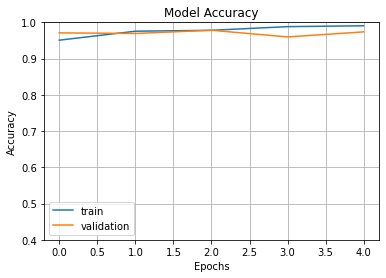

In [66]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [22]:
labels = train_set.class_names
img_height,img_width=224,224
dim = 3 
pred_a = []
val = '';

for i in test_Dataset['path']:
  image=cv2.imread(i)
  image_resized= cv2.resize(image, (img_height,img_width),dim)
  image=np.expand_dims(image_resized,axis=0)
  pred = resnet_model.predict(image)
  output_class=labels[np.argmax(pred)]
  pred_a.append(output_class)

In [75]:
test_Dataset['pred']= pred_a
test_Dataset.reset_index(inplace = True, drop = True)

## Some of the images that were classified incorrectly

The real class is normal predicted class is upside_down


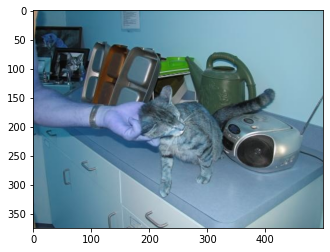

In [76]:
import cv2
img_height,img_width=224,224
dim = 3 
image=cv2.imread(test_Dataset['path'].iloc[24])
print("The real class is "+ test_Dataset['label'].iloc[24]+ " predicted class is "+ test_Dataset['pred'].iloc[24] )
imgplot = plt.imshow(image)
plt.show()    

The real class is normal predicted class is upside_down


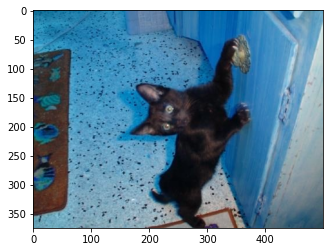

In [77]:
import cv2
img_height,img_width=224,224
dim = 3 
image=cv2.imread(test_Dataset['path'].iloc[278])
print("The real class is "+ test_Dataset['label'].iloc[278]+ " predicted class is "+ test_Dataset['pred'].iloc[278] )
imgplot = plt.imshow(image)
plt.show()    

The real class is normal predicted class is upside_down


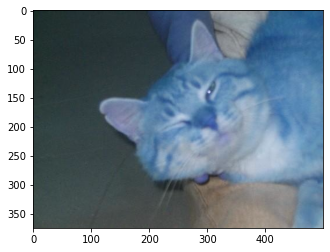

In [78]:
import cv2
img_height,img_width=224,224
dim = 3 
image=cv2.imread(test_Dataset['path'].iloc[849])
print("The real class is "+ test_Dataset['label'].iloc[849]+ " predicted class is "+ test_Dataset['pred'].iloc[849] )
imgplot = plt.imshow(image)
plt.show()    

The real class is upside_down predicted class is normal


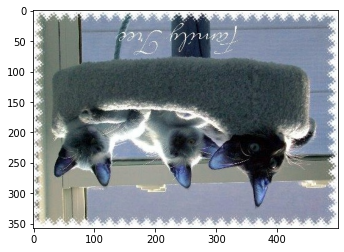

In [79]:
import cv2
img_height,img_width=224,224
dim = 3 
image=cv2.imread(test_Dataset['path'].iloc[1752])
print("The real class is "+ test_Dataset['label'].iloc[1752]+ " predicted class is "+ test_Dataset['pred'].iloc[1752] )
imgplot = plt.imshow(image)
plt.show()    

The real class is upside_down predicted class is normal


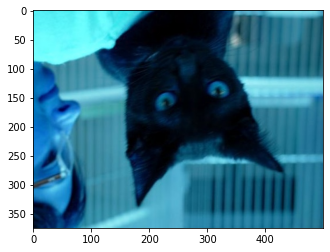

In [80]:
import cv2
img_height,img_width=224,224
dim = 3 
image=cv2.imread(test_Dataset['path'].iloc[1647])
print("The real class is "+ test_Dataset['label'].iloc[1647]+ " predicted class is "+ test_Dataset['pred'].iloc[1647] )
imgplot = plt.imshow(image)
plt.show()    

### what you might do to improve your model's performance ?
There are several things i can do for my model performance like do some Hyperparameter tuning ,cross validation.

We can also generate mask and use the semenatic segmentation models.
